# DESCRIPTION
* This is code for purely running already trained model 
* Unzip file to run models
* NOTE: The performance of this is going to skewed. The splitting of our original training and validation data was completely random, so when we run this code, even though it is completely random, training data has now been mixed with the validation data!

# Virtual Enviroments
* Virtual Enviroments are a cool idea in python
* We can create a virtual enviroment, containg independent packges
* Working with tensorflow and ai, these packages have lots of different versions and this insures we can run different packages for different projects
* ASK CHATGPT,YOUTUBE<> OR GOOGLE TO SETUP IF YOU WANT TO RUN EVERYTHING ON YOUR DEVICE 

# Batching - NOT REQUIRED BUT HELPFUL
* Batching is an important idea for speeding things up 
* Because our computations are "simple", they can be run simulateously on gpus 
* You can optimize your device to run different batches
* I have a mac, this mac setup is complicated but can be found at
https://developer.apple.com/metal/tensorflow-plugin/
* Macs have metal, Windows Computers have CUDA, whch you can google/ask chatgpt to set up
* lots of youtube videos for this 
* BE CAREFUL HIGH BATCH SIZES CAN OVERLOAD THE GPU

# Packages

In [1]:
# importing 
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from keras import regularizers, optimizers
from keras.optimizers import Adam, RMSprop
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from tensorflow.keras.models import load_model
from datasets import load_dataset

# File extracting
* Code for extracting the data, it is binary and is stored very complicated 
* RUN THIS, DO NOT CHANGE ANY CODE!
* Documentation - https://www.tensorflow.org/api_docs/python/tf/io


In [2]:
# this is a dictionairy used to define the structure
# of our binary file from before, tf documentation for reference
feature_description = {
    'image': tf.io.FixedLenFeature([], tf.string),
    'title': tf.io.FixedLenFeature([], tf.string),
    'price': tf.io.FixedLenFeature([], tf.float32),
    'unbalanced_vector': tf.io.VarLenFeature(tf.int64),
    'balanced_vector': tf.io.VarLenFeature(tf.int64),
    'unbalanced_model_vector': tf.io.VarLenFeature(tf.int64),
    'unbalanced_brand_vector': tf.io.VarLenFeature(tf.int64),
}

In [3]:
def parse_example(example_proto):
    parsed_example = tf.io.parse_single_example(example_proto, feature_description)
    image = tf.io.decode_jpeg(parsed_example['image'])
    title = tf.strings.lower(parsed_example['title'])
    price = parsed_example['price']
    unbalanced_vector = tf.sparse.to_dense(parsed_example['unbalanced_vector'])
    balanced_vector = tf.sparse.to_dense(parsed_example['balanced_vector'])
    unbalanced_model_vector = tf.sparse.to_dense(parsed_example['unbalanced_model_vector'])
    unbalanced_brand_vector = tf.sparse.to_dense(parsed_example['unbalanced_brand_vector'])
    return image, title, price, unbalanced_vector, balanced_vector, unbalanced_model_vector, unbalanced_brand_vector

In [4]:
dataset = tf.data.TFRecordDataset('Downloaded_Images_Binary_Brands_Models.tfrecords')
dataset = dataset.map(parse_example)

2023-11-29 17:44:17.713331: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-11-29 17:44:17.713357: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-11-29 17:44:17.713363: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-11-29 17:44:17.713395: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-29 17:44:17.713412: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Heres some code to show the formating of the file it has
* 3D Image Tensors (224,224,3) -> values 0 - 255 
* Unbalanced Price Vector -> (10)
* balanced Price Vector -> (10)
* unbalanced Brand Vector -> (10)
* unbalanced Model Vector -> (10)

Unbalanced Vector: [0 1 0 0 0 0 0 0 0 0]
Balanced Vector: [0 1 0 0 0 0 0 0 0 0]
Model Vector: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
Brand Vector: [1 0 0 0 0 0]
tf.Tensor(107.0, shape=(), dtype=float32)


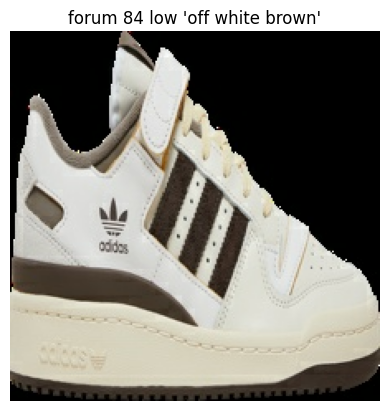

In [5]:
for image, title, price, unbalanced_vector, balanced_vector,unbalanced_model_vector,unbalanced_brand_vector in dataset.take(1):
    print("Unbalanced Vector:", unbalanced_vector.numpy())
    print("Balanced Vector:", balanced_vector.numpy())
    print("Model Vector:", unbalanced_model_vector.numpy())
    print("Brand Vector:", unbalanced_brand_vector.numpy())
    print(price)
    plt.imshow(image.numpy())
    plt.title(title.numpy().decode('utf-8'))
    plt.axis('off')  
    plt.show()

# Splitting up training and Testing Data
    * We are going to shuffle the data incase
    the website organizes the data in set, non-random
    way. 
## Trainng Testing split
    * 80% Training
    * 20% validation
    * We could use two validation splits if we wanted to but not enough data 


In [6]:
# Size of Data
buffer_size = sum([1 for _ in dataset])  
# Shuffle the data
shuffled_dataset = dataset.shuffle(buffer_size, reshuffle_each_iteration=False)
# 80/20 Split, Taking will take the first 80% and skip will take the last
train_size = int(0.8 * buffer_size)
train_dataset = shuffled_dataset.take(train_size)
val_dataset = shuffled_dataset.skip(train_size)

### Checking shuffled data

Unbalanced Vector: [0 0 0 1 0 0 0 0 0 0]
Balanced Vector: [0 0 0 0 0 0 0 1 0 0]
Model Vector: [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Brand Vector: [0 1 0 0 0 0]
tf.Tensor(396.0, shape=(), dtype=float32)


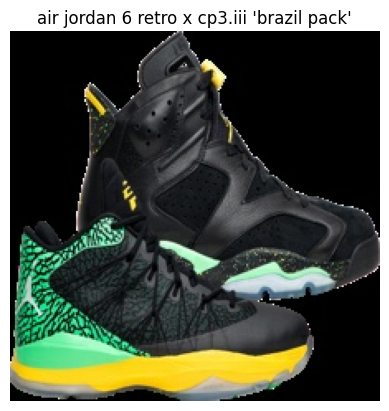

Unbalanced Vector: [0 0 1 0 0 0 0 0 0 0]
Balanced Vector: [0 0 0 0 0 1 0 0 0 0]
Model Vector: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
Brand Vector: [0 0 0 0 1 0]
tf.Tensor(272.0, shape=(), dtype=float32)


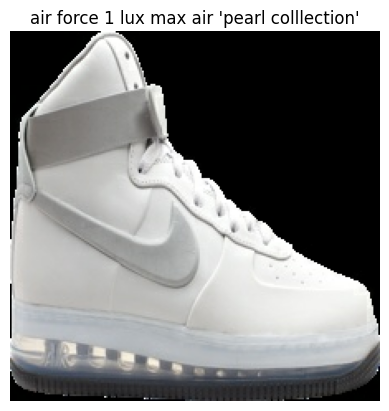

Unbalanced Vector: [0 0 0 1 0 0 0 0 0 0]
Balanced Vector: [0 0 0 0 0 0 1 0 0 0]
Model Vector: [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Brand Vector: [0 0 0 0 1 0]
tf.Tensor(300.0, shape=(), dtype=float32)


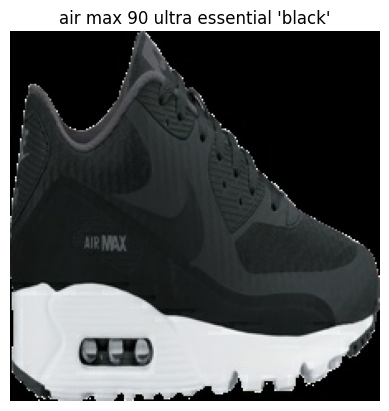

In [7]:
for image, title, price, unbalanced_vector, balanced_vector, unbalanced_model_vector,unbalanced_brand_vector in val_dataset.take(3):
    print("Unbalanced Vector:", unbalanced_vector.numpy())
    print("Balanced Vector:", balanced_vector.numpy())
    print("Model Vector:", unbalanced_model_vector.numpy())
    print("Brand Vector:", unbalanced_brand_vector.numpy())
    print(price)
    plt.imshow(image.numpy())
    plt.title(title.numpy().decode('utf-8'))
    plt.axis('off')  
    plt.show()

## Data Technique 1 - Normalization!
* This can be done simply by dividing by 255 (Pixel score)
* This is a good practice but can be done without it
* The preprocess function is taking in a dataset entry dividing the image by 255 
* It returns a a feature(3D image Tensor) and a response a vector
* So there are 4 codes storing unique datasets for ease


In [8]:
def preprocess(image, title, price, unbalanced_vector,balanced_vector, unbalanced_model_vector, unbalanced_brand_vector):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32) / 255.0
    return image, unbalanced_vector

unbalanced_vector_train_dataset = train_dataset.map(preprocess).batch(16)
unbalanced_vector_val_dataset = val_dataset.map(preprocess).batch(16)

In [9]:
def preprocess(image, title, price, unbalanced_vector,balanced_vector, unbalanced_model_vector, unbalanced_brand_vector):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32) / 255.0
    return image, balanced_vector

balanced_vector_train_dataset = train_dataset.map(preprocess).batch(16)
balanced_vector_val_dataset = val_dataset.map(preprocess).batch(16)

In [10]:
def preprocess(image, title, price, unbalanced_vector,balanced_vector, unbalanced_model_vector, unbalanced_brand_vector):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32) / 255.0
    return image, unbalanced_brand_vector

brand_vector_train_dataset = train_dataset.map(preprocess).batch(16)
brand_vector_val_dataset = val_dataset.map(preprocess).batch(16)

In [11]:
def preprocess(image, title, price, unbalanced_vector,balanced_vector, unbalanced_model_vector, unbalanced_brand_vector):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32) / 255.0
    return image, unbalanced_model_vector

model_vector_train_dataset = train_dataset.map(preprocess).batch(16)
model_vector_val_dataset = val_dataset.map(preprocess).batch(16)

# MODELS
* All training has been done already, we can load the model with the correct weights and biases (unzip file to load all models)
* just going to load the best model 

In [14]:
metrics_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

## Unbalanced 

In [15]:
unbalanced_model = load_model('Model_Keras_Files/unbalanced_model.keras')


### Predictions Code

In [16]:
def preprocess(image, title, price, unbalanced_vector,balanced_vector, unbalanced_model_vector, unbalanced_brand_vector):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32) / 255.0
    return image, unbalanced_vector, title

unbalanced_predictions_dataset = val_dataset.map(preprocess).batch(16)
predictions = unbalanced_model.predict(unbalanced_predictions_dataset)

# Initialize an array of zeros with the same shape as predictions
unbalanced_binary_predictions = np.zeros_like(predictions, dtype=int)

# Iterate over all predictions and set the max value index to 1
for i, prediction in enumerate(predictions):
    max_index = np.argmax(prediction)
    unbalanced_binary_predictions[i, max_index] = 1

2023-11-29 17:44:21.483229: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


150/150 [==============================] - 3s 10ms/step


2023-11-29 17:44:24.109352: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4801011341290603921


In [17]:
true_labels = []
predicted_labels = []
unbalanced_title = []

binary_predictions_list = unbalanced_binary_predictions.tolist()
prediction_count = 0

for batch in unbalanced_predictions_dataset:
    images, labels, batch_titles = batch
    for i in range(len(labels)):
        true_label = labels[i].numpy()
        true_labels.append(true_label)
        predicted_label = np.array(binary_predictions_list[prediction_count])
        predicted_labels.append(predicted_label)
        prediction_count += 1
        title = batch_titles[i]  
        if isinstance(title, tf.Tensor):  
            title = title.numpy()  
        unbalanced_title.append(title)  

true_labels_np = np.array(true_labels)
predicted_labels_np = np.array(predicted_labels)
print(true_labels_np.shape)
print(predicted_labels_np.shape)

(2386, 10)
(2386, 10)


In [18]:
true_labels_1d = np.argmax(true_labels_np, axis=1)
predicted_labels_1d = np.argmax(predicted_labels_np, axis=1)
unbalanced_cm = confusion_matrix(true_labels_1d, predicted_labels_1d)

In [19]:
unbalanced_price_list = ['0-100', '100-200', '200-300', '300-400', '400-500', '500-600',
'600-700', '700-800', '800-900', '900+']
unbalanced_prob_price_list = ['Probability 0-100', 'Probability 100-200', 'Probability 200-300', 'Probability 300-400', 'Probability 400-500', 'Probability 500-600',
'Probability 600-700', 'Probability 700-800', 'Probability 800-900', 'Probability 900+']

In [20]:
unbalanced_df = pd.DataFrame(predictions, columns = unbalanced_prob_price_list)
for i in range(true_labels_np.shape[1]):
    unbalanced_df[unbalanced_price_list[i]] = true_labels_np[:, i]
unbalanced_df['Title'] = unbalanced_title
unbalanced_df

,Probability 0-100,Probability 100-200,Probability 200-300,Probability 300-400,Probability 400-500,Probability 500-600,Probability 600-700,Probability 700-800,Probability 800-900,Probability 900+,...,100-200,200-300,300-400,400-500,500-600,600-700,700-800,800-900,900+,Title
0,0.028974,0.272661,0.359175,0.168391,0.034619,0.037385,0.020277,0.003964,0.003826,0.070727,...,0,0,1,0,0,0,0,0,0,"b""air jordan 6 retro x cp3.iii 'brazil pack'"""
1,0.196721,0.466892,0.128530,0.076148,0.063923,0.020771,0.015240,0.014257,0.004802,0.012716,...,0,1,0,0,0,0,0,0,0,"b""air force 1 lux max air 'pearl colllection'"""
2,0.115440,0.251614,0.249253,0.041337,0.117751,0.095260,0.019254,0.013273,0.041668,0.055150,...,0,0,1,0,0,0,0,0,0,"b""air max 90 ultra essential 'black'"""
3,0.064691,0.124026,0.260553,0.056264,0.090308,0.261914,0.023643,0.033091,0.034313,0.051197,...,1,0,0,0,0,0,0,0,0,"b""air force 1 low '07 lv8 emb 'world champ - l..."
4,0.078613,0.398745,0.202486,0.024021,0.034072,0.060137,0.023092,0.035269,0.030772,0.112793,...,1,0,0,0,0,0,0,0,0,"b""air jordan 1 low 'triple black' 2022"""
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2381,0.019941,0.097928,0.285959,0.052941,0.122346,0.149109,0.016005,0.025953,0.007169,0.222650,...,0,0,1,0,0,0,0,0,0,"b""murasaki sports x sb dunk low 'ride life'"""
2382,0.238745,0.336998,0.116236,0.057496,0.083403,0.039509,0.049596,0.013076,0.032343,0.032598,...,0,0,0,0,0,0,0,1,0,"b""dunk high premium sb 'dinosaur jr'"""
2383,0.090425,0.241310,0.102335,0.066743,0.082679,0.076966,0.039469,0.052820,0.015594,0.231658,...,0,0,1,0,0,0,0,0,0,"b""dunk high premium 'ultimate glory'"""
2384,0.101433,0.258992,0.399188,0.023167,0.038133,0.046681,0.028693,0.032101,0.032327,0.039285,...,0,0,0,0,0,0,0,0,1,"b""staple x air max 90 premium 'navigation'"""


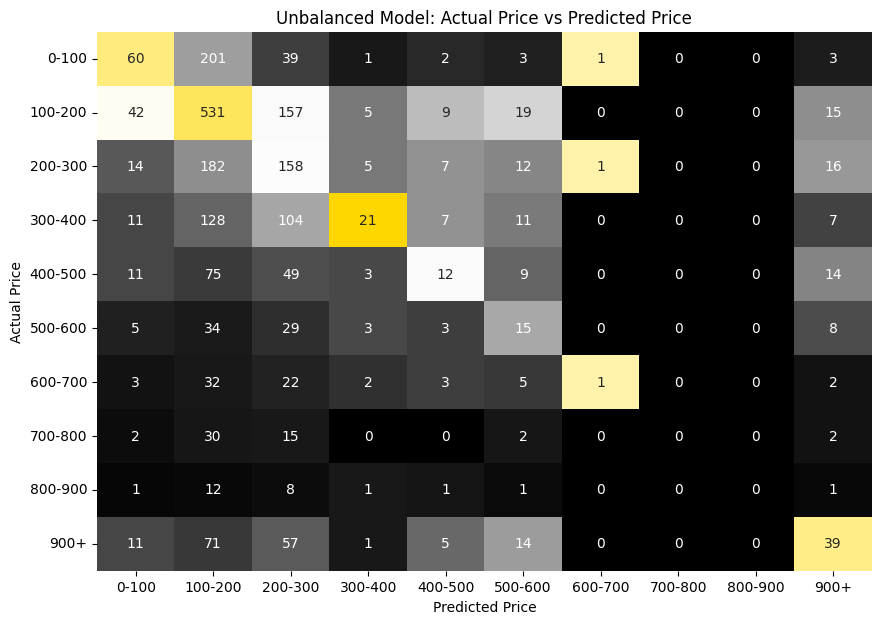

In [21]:
cm_df = pd.DataFrame(unbalanced_cm, index=unbalanced_price_list, columns=unbalanced_price_list)

column_sums = cm_df.sum(axis=0)
cm_df_normalized = cm_df.div(column_sums.where(column_sums != 0, 1), axis=1)

colors = ["black", "white", "gold"] 
cmap = LinearSegmentedColormap.from_list("BlGdBr", colors)

plt.figure(figsize=(10, 7))
ax = sns.heatmap(cm_df_normalized, annot=True, fmt=".2f", cbar=False, cmap=cmap)

for i in range(cm_df.shape[0]):
    for j in range(cm_df.shape[1]):
        text = ax.texts[i * cm_df.shape[1] + j]
        text.set_text(int(cm_df.iloc[i, j]))

plt.ylabel('Actual Price')
plt.xlabel('Predicted Price')
plt.title('Unbalanced Model: Actual Price vs Predicted Price')
plt.show()

In [22]:
unbalanced_accuracy = accuracy_score(true_labels, predicted_labels)
unbalanced_precision = precision_score(true_labels, predicted_labels, average='macro')
unbalanced_recall = recall_score(true_labels, predicted_labels, average='macro')
unbalanced_f1 = f1_score(true_labels, predicted_labels, average='macro')
unbalanced_report = classification_report(true_labels, predicted_labels, target_names=unbalanced_price_list)

unbalanced_metrics = pd.DataFrame([{
    'Model': 'Unbalanced Price Model',
    'Accuracy': unbalanced_accuracy,
    'Precision': unbalanced_precision,
    'Recall': unbalanced_recall,
    'F1 Score': unbalanced_f1
}])
metrics_df = pd.concat([metrics_df, unbalanced_metrics], ignore_index=True)


print(f"Unbalanced Accuracy: {unbalanced_accuracy}")
print(f"Unbalanced Precision: {unbalanced_precision}")
print(f"Unbalanced Recall: {unbalanced_recall}")
print(f"Unbalanced F1 Score: {unbalanced_f1}")
print(unbalanced_report)

Unbalanced Accuracy: 0.35079631181894383
Unbalanced Precision: 0.2639923563704122
Unbalanced Recall: 0.17839907755268755
Unbalanced F1 Score: 0.17509840404600074
              precision    recall  f1-score   support

       0-100       0.38      0.19      0.26       310
     100-200       0.41      0.68      0.51       778
     200-300       0.25      0.40      0.31       395
     300-400       0.50      0.07      0.13       289
     400-500       0.24      0.07      0.11       173
     500-600       0.16      0.15      0.16        97
     600-700       0.33      0.01      0.03        70
     700-800       0.00      0.00      0.00        51
     800-900       0.00      0.00      0.00        25
        900+       0.36      0.20      0.26       198

   micro avg       0.35      0.35      0.35      2386
   macro avg       0.26      0.18      0.18      2386
weighted avg       0.35      0.35      0.30      2386
 samples avg       0.35      0.35      0.35      2386



/Users/kelley/anaconda3/envs/snakeEnv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kelley/anaconda3/envs/snakeEnv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/var/folders/9q/kg9gzt1s4d36gdnlr8nf75m40000gn/T/ipykernel_21679/4210602627.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the rele

## Balanced

In [23]:
balanced_model = load_model('Model_Keras_Files/balanced_model.keras')

In [24]:
def preprocess(image, title, price, unbalanced_vector,balanced_vector, unbalanced_model_vector, unbalanced_brand_vector):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32) / 255.0
    return image, balanced_vector, title

balanced_predictions_dataset = val_dataset.map(preprocess).batch(16)

In [25]:
predictions = balanced_model.predict(balanced_predictions_dataset)

# Initialize an array of zeros with the same shape as predictions
balanced_binary_predictions = np.zeros_like(predictions, dtype=int)

# Iterate over all predictions and set the max value index to 1
for i, prediction in enumerate(predictions):
    max_index = np.argmax(prediction)
    balanced_binary_predictions[i, max_index] = 1

150/150 [==============================] - 3s 10ms/step


2023-11-29 17:44:28.480627: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4801011341290603921


In [26]:
balanced_price_list = ['17-93', '93-116', '116-143', '143-177', '177-217', '217-272',
'272-340', '340-457', '457-766', '766+']
prob_balanced_price_list = ['Probability 17-93', 'Probability 93-116', 'Probability 116-143', 'Probability 143-177', 'Probability 177-217', 'Probability 217-272',
'Probability 272-340', 'Probability 340-457', 'Probability 457-766', 'Probability 766+']

In [27]:
true_labels = []
predicted_labels = []
titles = []

binary_predictions_list = balanced_binary_predictions.tolist()
prediction_count = 0

for batch in balanced_predictions_dataset:
    images, labels,batch_titles = batch
    for i in range(len(labels)):
        true_label = labels[i].numpy()
        true_labels.append(true_label)
        predicted_label = np.array(binary_predictions_list[prediction_count])
        predicted_labels.append(predicted_label)
        title = batch_titles[i]  
        if isinstance(title, tf.Tensor):  
            title = title.numpy()  

        titles.append(title)  
        prediction_count += 1

true_labels_np = np.array(true_labels)
predicted_labels_np = np.array(predicted_labels)
print(true_labels_np.shape)
print(predicted_labels_np.shape)

(2386, 10)
(2386, 10)


In [28]:
balanced_df = pd.DataFrame(predictions, columns = prob_balanced_price_list)
for i in range(true_labels_np.shape[1]):
    balanced_df[balanced_price_list[i]] = true_labels_np[:, i]
balanced_df['Title'] = titles
balanced_df


,Probability 17-93,Probability 93-116,Probability 116-143,Probability 143-177,Probability 177-217,Probability 217-272,Probability 272-340,Probability 340-457,Probability 457-766,Probability 766+,...,93-116,116-143,143-177,177-217,217-272,272-340,340-457,457-766,766+,Title
0,0.032721,0.091158,0.018050,0.038680,0.051660,0.153942,0.046897,0.082569,0.135377,0.348946,...,0,0,0,0,0,0,1,0,0,"b""air jordan 6 retro x cp3.iii 'brazil pack'"""
1,0.225295,0.068086,0.135983,0.175490,0.032923,0.161658,0.079889,0.054259,0.049889,0.016528,...,0,0,0,0,1,0,0,0,0,"b""air force 1 lux max air 'pearl colllection'"""
2,0.077356,0.066013,0.035334,0.109263,0.093213,0.190313,0.070275,0.091306,0.157236,0.109692,...,0,0,0,0,0,1,0,0,0,"b""air max 90 ultra essential 'black'"""
3,0.088040,0.067257,0.037887,0.089287,0.060294,0.210227,0.062403,0.121934,0.195295,0.067377,...,1,0,0,0,0,0,0,0,0,"b""air force 1 low '07 lv8 emb 'world champ - l..."
4,0.084718,0.092524,0.042111,0.057197,0.039243,0.107902,0.058688,0.019990,0.171955,0.325671,...,1,0,0,0,0,0,0,0,0,"b""air jordan 1 low 'triple black' 2022"""
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2381,0.023966,0.027748,0.039875,0.181904,0.047137,0.163068,0.058399,0.092309,0.172489,0.193105,...,0,0,0,0,0,0,1,0,0,"b""murasaki sports x sb dunk low 'ride life'"""
2382,0.163732,0.109929,0.080746,0.130665,0.058039,0.102163,0.088392,0.151013,0.062528,0.052793,...,0,0,0,0,0,0,0,0,1,"b""dunk high premium sb 'dinosaur jr'"""
2383,0.050991,0.061020,0.032681,0.073328,0.032810,0.152241,0.081540,0.092635,0.132436,0.290318,...,0,0,0,0,0,0,1,0,0,"b""dunk high premium 'ultimate glory'"""
2384,0.067400,0.081562,0.058784,0.070757,0.039661,0.288175,0.077683,0.037584,0.166512,0.111883,...,0,0,0,0,0,0,0,0,1,"b""staple x air max 90 premium 'navigation'"""


In [29]:
true_labels_1d = np.argmax(true_labels_np, axis=1)
predicted_labels_1d = np.argmax(predicted_labels_np, axis=1)
balanced_cm = confusion_matrix(true_labels_1d, predicted_labels_1d)
print(balanced_cm)

[[99 18 46 19  0 18  1  4 11 33]
 [60 41 55 15  1 36  5  3  5 33]
 [30 22 62 14  1 45  9  4 11 33]
 [22 26 46 23  2 48 10  6  9 34]
 [18 25 39 15  3 66  2  2 21 37]
 [19  6 30 11  0 70  6  7 24 41]
 [16 13 30  9  4 50 22 10 35 37]
 [17 14 41 16  1 50 23 30 33 52]
 [10 12 22  9  1 45 15  9 55 60]
 [16 14 28 15  2 31 11  9 20 97]]


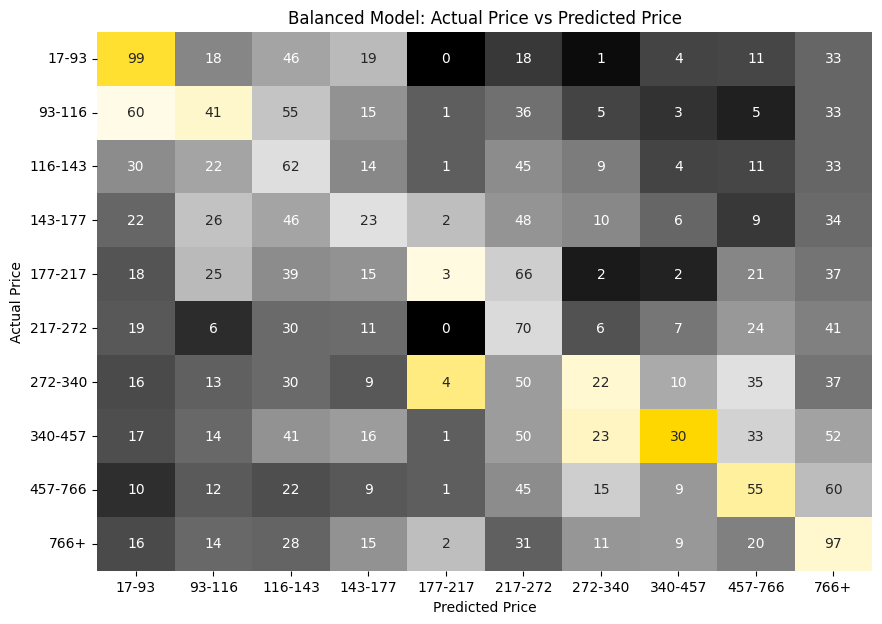

In [30]:
cm_df = pd.DataFrame(balanced_cm, index=balanced_price_list, columns=balanced_price_list)

column_sums = cm_df.sum(axis=0)
cm_df_normalized = cm_df.div(column_sums.where(column_sums != 0, 1), axis=1)

colors = ["black", "white", "gold"] 
cmap = LinearSegmentedColormap.from_list("BlGdBr", colors)

plt.figure(figsize=(10, 7))
ax = sns.heatmap(cm_df_normalized, annot=True, fmt=".2f", cbar=False, cmap=cmap)

for i in range(cm_df.shape[0]):
    for j in range(cm_df.shape[1]):
        text = ax.texts[i * cm_df.shape[1] + j]
        text.set_text(int(cm_df.iloc[i, j]))

plt.ylabel('Actual Price')
plt.xlabel('Predicted Price')
plt.title('Balanced Model: Actual Price vs Predicted Price')
plt.show()

In [31]:
balanced_accuracy = accuracy_score(true_labels, predicted_labels)
balanced_precision = precision_score(true_labels, predicted_labels, average='macro')
balanced_recall = recall_score(true_labels, predicted_labels, average='macro')
balanced_f1 = f1_score(true_labels, predicted_labels, average='macro')
balanced_report = classification_report(true_labels, predicted_labels, target_names=balanced_price_list)

balanced_metrics = pd.DataFrame([{
    'Model': 'Balanced Price Model',
    'Accuracy': balanced_accuracy,
    'Precision': balanced_precision,
    'Recall': balanced_recall,
    'F1 Score': balanced_f1
}])
metrics_df = pd.concat([metrics_df, balanced_metrics], ignore_index=True)

print(f"Balanced Accuracy: {balanced_accuracy}")
print(f"Balanced Precision: {balanced_precision}")
print(f"Balanced Recall: {balanced_recall}")
print(f"Balanced F1 Score: {balanced_f1}")
print(balanced_report)

Balanced Accuracy: 0.21039396479463537
Balanced Precision: 0.22290342825615245
Balanced Recall: 0.2105354336206418
Balanced F1 Score: 0.19083576285302298
              precision    recall  f1-score   support

       17-93       0.32      0.40      0.36       249
      93-116       0.21      0.16      0.18       254
     116-143       0.16      0.27      0.20       231
     143-177       0.16      0.10      0.12       226
     177-217       0.20      0.01      0.02       228
     217-272       0.15      0.33      0.21       214
     272-340       0.21      0.10      0.13       226
     340-457       0.36      0.11      0.17       277
     457-766       0.25      0.23      0.24       238
        766+       0.21      0.40      0.28       243

   micro avg       0.21      0.21      0.21      2386
   macro avg       0.22      0.21      0.19      2386
weighted avg       0.23      0.21      0.19      2386
 samples avg       0.21      0.21      0.21      2386



## Brand

In [32]:
brand_model_modified = load_model('Model_Keras_Files/brand_model_modified.keras')


In [33]:
def preprocess(image, title, price, unbalanced_vector,balanced_vector, unbalanced_model_vector, unbalanced_brand_vector):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32) / 255.0
    return image, unbalanced_brand_vector, title

brand_predictions_dataset = val_dataset.map(preprocess).batch(16)

In [34]:
predictions = brand_model_modified.predict(brand_predictions_dataset)

# Initialize an array of zeros with the same shape as predictions
brand_binary_mod_predictions = np.zeros_like(predictions, dtype=int)

# Iterate over all predictions and set the max value index to 1
for i, prediction in enumerate(predictions):
    max_index = np.argmax(prediction)
    brand_binary_mod_predictions [i, max_index] = 1

150/150 [==============================] - 3s 11ms/step


2023-11-29 17:44:33.132851: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4801011341290603921


In [35]:
brand_list = ['ADIDAS', 'AIR JORDAN', 'BAPESTA', 'NEW BALANCE', 'NIKE', 'YEEZY']
prob_brand_list = ['Probability ADIDAS', 'Probability AIR JORDAN', 'Probability BAPESTA', 'Probability NEW BALANCE', 'Probability NIKE', 'Probability YEEZY']

In [36]:
true_labels = []
predicted_labels = []
titles = []

binary_predictions_list = brand_binary_mod_predictions.tolist()
prediction_count = 0

for batch in brand_predictions_dataset:
    images, labels,batch_titles = batch
    for i in range(len(labels)):
        true_label = labels[i].numpy()
        true_labels.append(true_label)
        predicted_label = np.array(binary_predictions_list[prediction_count])
        predicted_labels.append(predicted_label)
        prediction_count += 1
        title = batch_titles[i]  
        if isinstance(title, tf.Tensor):  
            title = title.numpy()  
        titles.append(title)  

true_labels_np = np.array(true_labels)
predicted_labels_np = np.array(predicted_labels)
print(true_labels_np.shape)
print(predicted_labels_np.shape)

(2386, 6)
(2386, 6)


In [37]:
true_labels_1d = np.argmax(true_labels_np, axis=1)
predicted_labels_1d = np.argmax(predicted_labels_np, axis=1)
brand_modified_cm = confusion_matrix(true_labels_1d, predicted_labels_1d)
print(brand_modified_cm)

[[ 269    1    0    0    3    0]
 [   0  478    0    0   17    0]
 [   6    5   65    0    9    0]
 [   0    0    0  128    3    0]
 [   3   10    0    0 1343    0]
 [   0    0    0    0    0   46]]


In [38]:
brand_df = pd.DataFrame(predictions, columns = prob_brand_list)
for i in range(true_labels_np.shape[1]):
    brand_df[brand_list[i]] = true_labels_np[:, i]
brand_df['Title'] = titles
brand_df

,Probability ADIDAS,Probability AIR JORDAN,Probability BAPESTA,Probability NEW BALANCE,Probability NIKE,Probability YEEZY,ADIDAS,AIR JORDAN,BAPESTA,NEW BALANCE,NIKE,YEEZY,Title
0,7.091048e-10,1.000000e+00,2.724188e-15,1.357838e-12,3.600517e-09,7.545107e-11,0,1,0,0,0,0,"b""air jordan 6 retro x cp3.iii 'brazil pack'"""
1,1.868521e-17,3.144015e-16,9.468920e-22,4.381408e-18,1.000000e+00,1.936951e-15,0,0,0,0,1,0,"b""air force 1 lux max air 'pearl colllection'"""
2,7.971626e-16,8.442799e-12,4.761729e-22,3.957443e-17,1.000000e+00,1.766950e-15,0,0,0,0,1,0,"b""air max 90 ultra essential 'black'"""
3,1.325035e-20,1.500924e-16,2.109130e-17,1.926511e-17,1.000000e+00,3.478867e-17,0,0,0,0,1,0,"b""air force 1 low '07 lv8 emb 'world champ - l..."
4,5.488411e-07,9.999985e-01,1.313771e-14,1.092582e-12,1.028297e-06,3.773016e-11,0,1,0,0,0,0,"b""air jordan 1 low 'triple black' 2022"""
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2381,7.196508e-10,1.135023e-04,9.413884e-07,2.064886e-10,9.998856e-01,2.152709e-11,0,0,0,0,1,0,"b""murasaki sports x sb dunk low 'ride life'"""
2382,2.306956e-12,4.161679e-09,9.760583e-15,8.700765e-13,1.000000e+00,5.615858e-12,0,0,0,0,1,0,"b""dunk high premium sb 'dinosaur jr'"""
2383,7.495743e-12,1.269800e-12,6.678402e-16,5.659872e-15,1.000000e+00,2.486684e-13,0,0,0,0,1,0,"b""dunk high premium 'ultimate glory'"""
2384,2.134929e-19,1.900465e-15,4.247534e-20,8.591547e-18,1.000000e+00,3.899287e-17,0,0,0,0,1,0,"b""staple x air max 90 premium 'navigation'"""


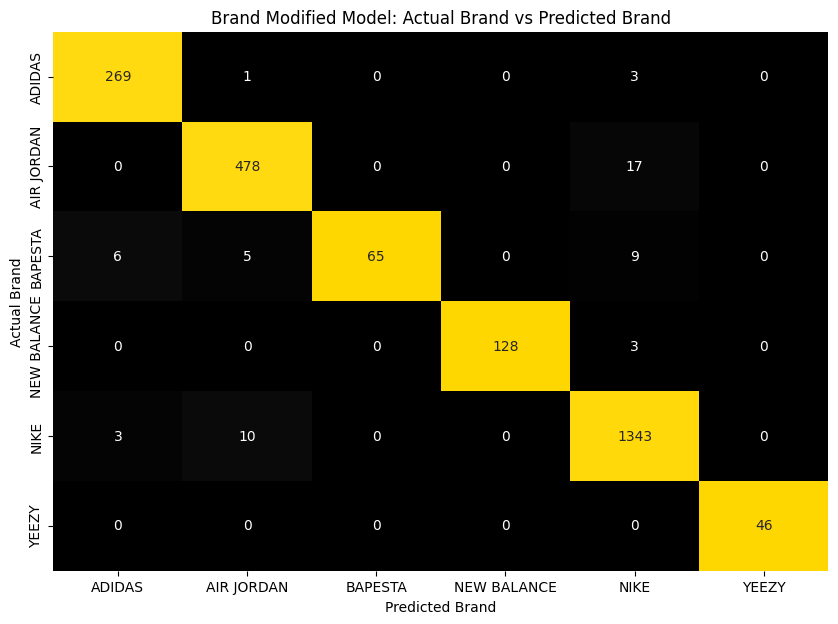

In [39]:
cm_df = pd.DataFrame(brand_modified_cm, index=brand_list, columns=brand_list)

cm_df_normalized = cm_df.div(cm_df.sum(axis=0), axis=1)

colors = ["black", "white", "gold", ] 
cmap = LinearSegmentedColormap.from_list("BlGdBr", colors)

plt.figure(figsize=(10, 7))
ax = sns.heatmap(cm_df_normalized, annot=True, fmt=".2f", cbar=False, cmap=cmap)

for i in range(cm_df.shape[0]):
    for j in range(cm_df.shape[1]):
        text = ax.texts[i * cm_df.shape[1] + j]
        text.set_text(int(cm_df.iloc[i, j]))

plt.ylabel('Actual Brand')
plt.xlabel('Predicted Brand')
plt.title('Brand Modified Model: Actual Brand vs Predicted Brand')
plt.show()

In [40]:
brand_modified_accuracy = accuracy_score(true_labels, predicted_labels)
brand_modified_precision = precision_score(true_labels, predicted_labels, average='macro')
brand_modified_recall = recall_score(true_labels, predicted_labels, average='macro')
brand_modified_f1 = f1_score(true_labels, predicted_labels, average='macro')
brand_modified_report = classification_report(true_labels, predicted_labels, target_names=brand_list)

brand_modified_metrics = pd.DataFrame([{
    'Model': 'Brand Modified Model',
    'Accuracy': brand_modified_accuracy,
    'Precision': brand_modified_precision,
    'Recall': brand_modified_recall,
    'F1 Score': brand_modified_f1
}])
metrics_df = pd.concat([metrics_df, brand_modified_metrics], ignore_index=True)


print(f"Brand Modified Accuracy: {brand_modified_accuracy}")
print(f"Brand Modified Precision: {brand_modified_precision}")
print(f"Brand Modified Recall: {brand_modified_recall}")
print(f"Brand Modified F1 Score: {brand_modified_f1}")
print(brand_modified_report)

Brand Modified Accuracy: 0.9761106454316848
Brand Modified Precision: 0.9853274180067061
Brand Modified Recall: 0.9472037748916243
Brand Modified F1 Score: 0.9636076117451956
              precision    recall  f1-score   support

      ADIDAS       0.97      0.99      0.98       273
  AIR JORDAN       0.97      0.97      0.97       495
     BAPESTA       1.00      0.76      0.87        85
 NEW BALANCE       1.00      0.98      0.99       131
        NIKE       0.98      0.99      0.98      1356
       YEEZY       1.00      1.00      1.00        46

   micro avg       0.98      0.98      0.98      2386
   macro avg       0.99      0.95      0.96      2386
weighted avg       0.98      0.98      0.98      2386
 samples avg       0.98      0.98      0.98      2386



## Model

In [41]:
model_model_modified = load_model('Model_Keras_Files/model_model_modified.keras')

In [42]:
def preprocess(image, title, price, unbalanced_vector,balanced_vector, unbalanced_model_vector, unbalanced_brand_vector):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32) / 255.0
    return image, unbalanced_model_vector, title

model_predictions_dataset = val_dataset.map(preprocess).batch(16)

In [43]:
predictions = model_model_modified.predict(model_predictions_dataset)

# Initialize an array of zeros with the same shape as predictions
model_binary_mod_predictions = np.zeros_like(predictions, dtype=int)

# Iterate over all predictions and set the max value index to 1
for i, prediction in enumerate(predictions):
    max_index = np.argmax(prediction)
    model_binary_mod_predictions[i, max_index] = 1

150/150 [==============================] - 3s 10ms/step


2023-11-29 17:44:37.854266: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 4801011341290603921


In [44]:
model_list = ['NB 2002R', 'AIR MAX 1', 'NIKE AIR MAX 90', 'AJ 1','AJ 11', 'AJ 12', 'AJ 2', 
'AJ 3', 'AJ 4', 'AJ 5', 'AJ 6', 'BAPESTA', 'NIKE DUNK LOW','NIKE DUNK HIGH', 'NB550',
'NB990', 'ADIDAS STAN SMITH', 'YZY 700', 'YZY 350', 'YZY RNR', 'NIKE AF1', 
'ADIDAS FORUM', 'ADIDAS SAMBA', 'YZY SLIDES'
]
prob_model_list = ['Probability NB 2002R', 'Probability AIR MAX 1', 'Probability NIKE AIR MAX 90', 'Probability AJ 1','Probability AJ 11', 'Probability AJ 12', 'Probability AJ 2', 
'Probability AJ 3', 'Probability AJ 4', 'Probability AJ 5', 'Probability AJ 6', 'Probability BAPESTA', 'Probability NIKE DUNK LOW','Probability NIKE DUNK HIGH', 'Probability NB550',
'Probability NB990', 'Probability ADIDAS STAN SMITH', 'Probability YZY 700', 'Probability YZY 350', 'Probability YZY RNR', 'Probability NIKE AF1', 
'ADIDAS FORUM', 'ADIDAS SAMBA', 'YZY SLIDES'
]

In [45]:
true_labels = []
predicted_labels = []
titles = []

binary_predictions_list = model_binary_mod_predictions.tolist()
prediction_count = 0

for batch in model_predictions_dataset:
    images, labels, batch_titles = batch
    for i in range(len(labels)):
        true_label = labels[i].numpy()
        true_labels.append(true_label)
        predicted_label = np.array(binary_predictions_list[prediction_count])
        predicted_labels.append(predicted_label)
        title = batch_titles[i]  
        if isinstance(title, tf.Tensor):  
            title = title.numpy()  
        titles.append(title)  
        prediction_count += 1

true_labels_np = np.array(true_labels)
predicted_labels_np = np.array(predicted_labels)
print(true_labels_np.shape)
print(predicted_labels_np.shape)

(2386, 24)
(2386, 24)


In [46]:
print()
true_labels_1d = np.argmax(true_labels_np, axis=1)
predicted_labels_1d = np.argmax(predicted_labels_np, axis=1)
model_modified_cm = confusion_matrix(true_labels_1d, predicted_labels_1d)
print(model_modified_cm)


[[ 39   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0 177   0   3   0   0   0   1   0   0   0   0   0   0   0   1   0   0
    0   0  13   0   0   0]
 [  0   2 211   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   2   0 253   0   0   7   1   0   0   0   1   0   0   0   0   0   0
    0   0   0   1   0   0]
 [  0   0   0   0  29   0   0   2   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   0  32   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   7   0   0  24   1   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   1   0]
 [  0   0   0   2   0   0   0  36   0   0   2   0   0   0   0   0   0   0
    0   0   3   0   0   0]
 [  0   0   0   0   0   0   0   0  38   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   1   1   0   0   5   1   0  22   0   0   0   0   0   0   0   0
    0   0   0   

In [47]:
model_df = pd.DataFrame(predictions, columns = prob_model_list)
for i in range(true_labels_np.shape[1]):
    model_df[model_list[i]] = true_labels_np[:, i]
model_df['Title'] = titles

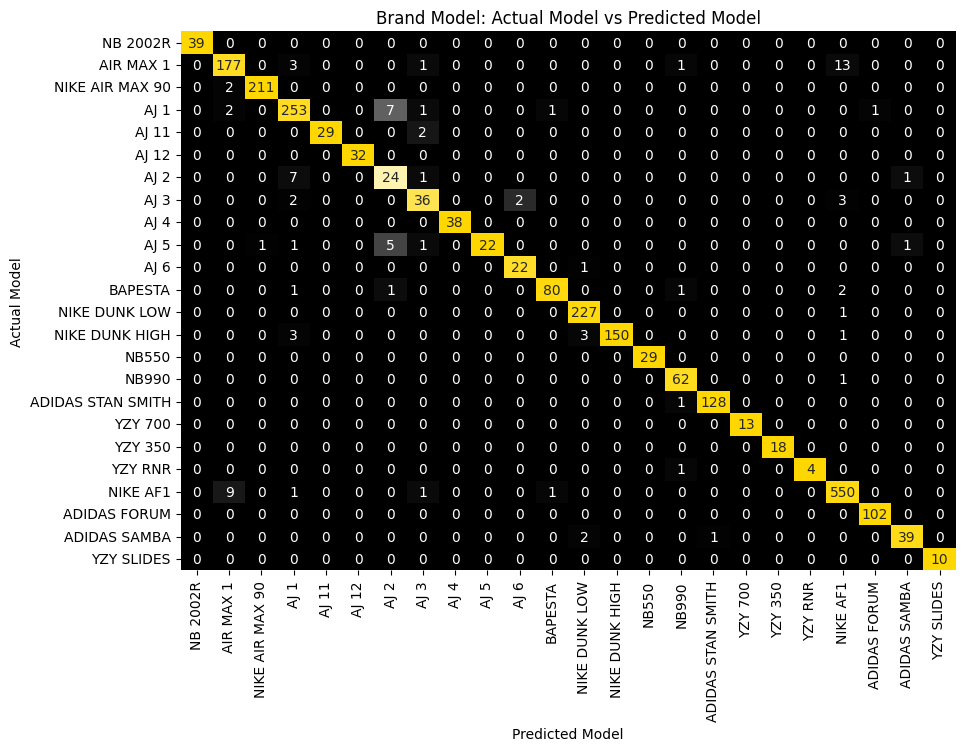

In [48]:
cm_df = pd.DataFrame(model_modified_cm, index=model_list, columns=model_list)

cm_df_normalized = cm_df.div(cm_df.sum(axis=0), axis=1)

colors = ["black", "white", "gold", ] 
cmap = LinearSegmentedColormap.from_list("BlGdBr", colors)

plt.figure(figsize=(10, 7))
ax = sns.heatmap(cm_df_normalized, annot=True, fmt=".2f", cbar=False, cmap=cmap)

for i in range(cm_df.shape[0]):
    for j in range(cm_df.shape[1]):
        text = ax.texts[i * cm_df.shape[1] + j]
        text.set_text(int(cm_df.iloc[i, j]))

plt.ylabel('Actual Model')
plt.xlabel('Predicted Model')
plt.title('Brand Model: Actual Model vs Predicted Model')
plt.show()

In [49]:
model_modified_accuracy = accuracy_score(true_labels, predicted_labels)
model_modified_precision = precision_score(true_labels, predicted_labels, average='macro')
model_modified_recall = recall_score(true_labels, predicted_labels, average='macro')
model_modified_f1 = f1_score(true_labels, predicted_labels, average='macro')
model_modified_report = classification_report(true_labels, predicted_labels, target_names=model_list)

model_modified_metrics = pd.DataFrame([{
    'Model': 'Modified Model Model',
    'Accuracy': model_modified_accuracy,
    'Precision': model_modified_precision,
    'Recall': model_modified_recall,
    'F1 Score': model_modified_f1
}])
metrics_df = pd.concat([metrics_df, model_modified_metrics], ignore_index=True)

print(f"Model Modified Accuracy: {model_modified_accuracy}")
print(f"Model Modified Precision: {model_modified_precision}")
print(f"Model Modified Recall: {model_modified_recall}")
print(f"Model Modified F1 Score: {model_modified_f1}")
print(model_modified_report)

Model Modified Accuracy: 0.9618608549874267
Model Modified Precision: 0.9603833248066618
Model Modified Recall: 0.9414576398531528
Model Modified F1 Score: 0.9491929531580796
                   precision    recall  f1-score   support

         NB 2002R       1.00      1.00      1.00        39
        AIR MAX 1       0.93      0.91      0.92       195
  NIKE AIR MAX 90       1.00      0.99      0.99       213
             AJ 1       0.93      0.95      0.94       265
            AJ 11       1.00      0.94      0.97        31
            AJ 12       1.00      1.00      1.00        32
             AJ 2       0.65      0.73      0.69        33
             AJ 3       0.84      0.84      0.84        43
             AJ 4       1.00      1.00      1.00        38
             AJ 5       1.00      0.71      0.83        31
             AJ 6       0.92      0.96      0.94        23
          BAPESTA       0.98      0.94      0.96        85
    NIKE DUNK LOW       0.97      1.00      0.98       22

## Overall performance

In [50]:
print(metrics_df)

                    Model  Accuracy  Precision    Recall  F1 Score
0  Unbalanced Price Model  0.350796   0.263992  0.178399  0.175098
1    Balanced Price Model  0.210394   0.222903  0.210535  0.190836
2    Brand Modified Model  0.976111   0.985327  0.947204  0.963608
3    Modified Model Model  0.961861   0.960383  0.941458  0.949193


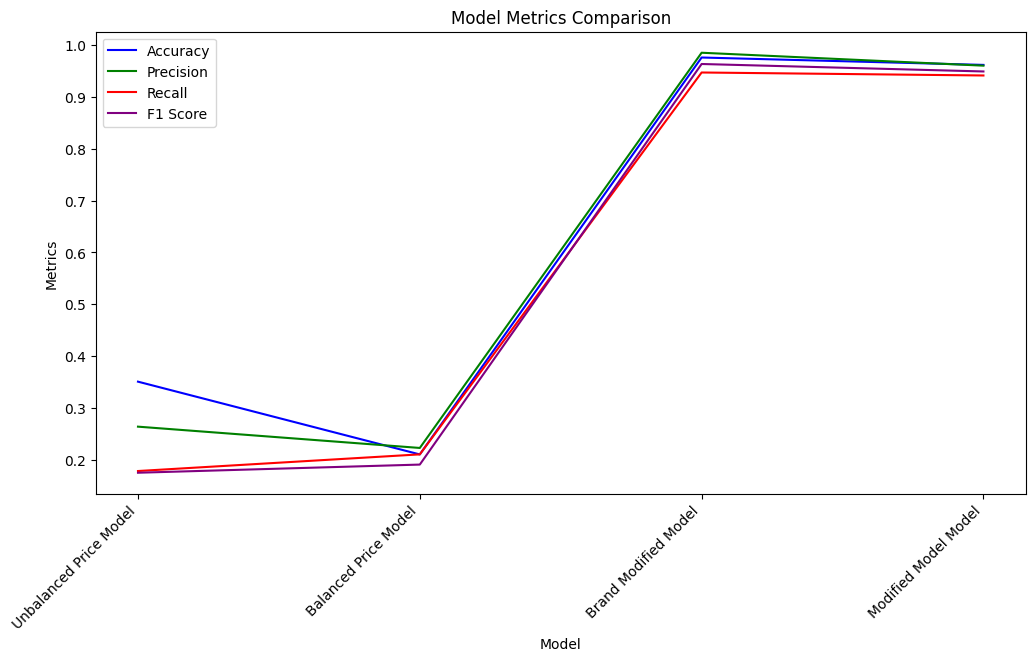

In [51]:
plt.figure(figsize=(12, 6))
plt.plot(metrics_df['Model'], metrics_df['Accuracy'], color='blue', label='Accuracy')
plt.plot(metrics_df['Model'], metrics_df['Precision'], color='green', label='Precision')
plt.plot(metrics_df['Model'], metrics_df['Recall'], color='red', label='Recall')
plt.plot(metrics_df['Model'], metrics_df['F1 Score'], color='purple', label='F1 Score')
plt.xlabel('Model')
plt.ylabel('Metrics')
plt.title('Model Metrics Comparison')
plt.xticks(rotation=45, ha="right") 
plt.legend()  
plt.show()

# Saving to CSV

In [53]:
merged_df = pd.merge(unbalanced_df, balanced_df, on="Title", how="outer")
merged_df

,Probability 0-100,Probability 100-200,Probability 200-300,Probability 300-400,Probability 400-500,Probability 500-600,Probability 600-700,Probability 700-800,Probability 800-900,Probability 900+,...,17-93,93-116,116-143,143-177,177-217,217-272,272-340,340-457,457-766,766+
0,0.028974,0.272661,0.359175,0.168391,0.034619,0.037385,0.020277,0.003964,0.003826,0.070727,...,0,0,0,0,0,0,0,1,0,0
1,0.028974,0.272661,0.359175,0.168391,0.034619,0.037385,0.020277,0.003964,0.003826,0.070727,...,0,0,0,0,0,0,0,1,0,0
2,0.028974,0.272661,0.359175,0.168391,0.034619,0.037385,0.020277,0.003964,0.003826,0.070727,...,0,0,0,0,0,0,0,1,0,0
3,0.028974,0.272661,0.359175,0.168391,0.034619,0.037385,0.020277,0.003964,0.003826,0.070727,...,0,0,0,0,0,0,0,1,0,0
4,0.196721,0.466892,0.128530,0.076148,0.063923,0.020771,0.015240,0.014257,0.004802,0.012716,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3845,0.147821,0.472047,0.213618,0.020915,0.031554,0.019641,0.022099,0.017178,0.035391,0.019735,...,0,0,1,0,0,0,0,0,0,0
3846,0.019941,0.097928,0.285959,0.052941,0.122346,0.149109,0.016005,0.025953,0.007169,0.222650,...,0,0,0,0,0,0,0,1,0,0
3847,0.238745,0.336998,0.116236,0.057496,0.083403,0.039509,0.049596,0.013076,0.032343,0.032598,...,0,0,0,0,0,0,0,0,0,1
3848,0.090425,0.241310,0.102335,0.066743,0.082679,0.076966,0.039469,0.052820,0.015594,0.231658,...,0,0,0,0,0,0,0,1,0,0
